In [1]:
#Import Required Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from pandas import ExcelWriter
from pandas import ExcelFile
import glob
from termcolor import colored
%matplotlib inline

In [72]:
Car_Data_Frame = pd.read_csv("2022.03.10 C-CAN 구쏘울 정상.trc", encoding='cp949')
Car_Data_Frame = Car_Data_Frame['CAN_Data'].str.split('Rx         ',n=1,expand=True)
Car_Data_Frame = Car_Data_Frame.rename(columns={0:'Time', 1:'Payload'})

#Splitting Time
Car_Data_Frame_Time = Car_Data_Frame['Time'].str.split(')',n=2,expand=True)
Car_Data_Frame_Time = Car_Data_Frame_Time.rename(columns={0:'Serial', 1:'Time'})
Car_Data_Frame_Time = Car_Data_Frame_Time.Time.astype(float)
Car_Data_Frame_Time = pd.DataFrame(Car_Data_Frame_Time).rename(columns={0:'Time'})

#Splitting Payload
Car_Data_Frame_Time_ID = Car_Data_Frame['Payload'].str.split('  ',n=2,expand=True)
Car_Data_Frame_Time_ID = Car_Data_Frame_Time_ID.rename(columns={0:'CAN_ID', 1:'DLC', 2:'Payload_8_hex'})

#Splitting Payload with each PID
Car_Data_Frame_Time_Payload_hex = Car_Data_Frame_Time_ID['Payload_8_hex'].str.split(' ',n=7,expand=True)
Car_Data_Frame_Time_Payload_hex = Car_Data_Frame_Time_Payload_hex.rename(
    columns={0:'One', 1:'Two', 2:'Three', 3:'Four', 4:'Five', 5:'Six', 6:'Seven', 7:'Eight'})

#Joind all data set
Car_Data_Frame = pd.concat([pd.DataFrame(Car_Data_Frame_Time), pd.DataFrame(Car_Data_Frame_Time_ID), 
                            pd.DataFrame(Car_Data_Frame_Time_Payload_hex)], axis=1)
Car_Data_Frame = Car_Data_Frame.sort_values(['Time'], ignore_index = True)

#Time Gap Calculation (Full_Data_Time_Gap)
Time_gap = [0]
k4 = 1
lenth = len(Car_Data_Frame)-1

for k in Car_Data_Frame.Time:
    k2 = float(Car_Data_Frame.Time[k4]) - float(k)
    Time_gap.append(k2)
    if k4 >= lenth:
        break
    k4 = k4 + 1

#Joind with time gap
Car_Data_Frame = pd.concat([pd.DataFrame(Car_Data_Frame), pd.DataFrame(Time_gap)], axis=1)
Car_Data_Frame = Car_Data_Frame.rename(columns={0:'Full_Data_Time_Gap'})
print(colored('Total Amount of Data: ', 'blue', attrs=['bold']),len(Car_Data_Frame))

Total Amount of Data:  1303127


Text(0.5, 1.0, 'Data Cangeing Pattern According to Time Gap')

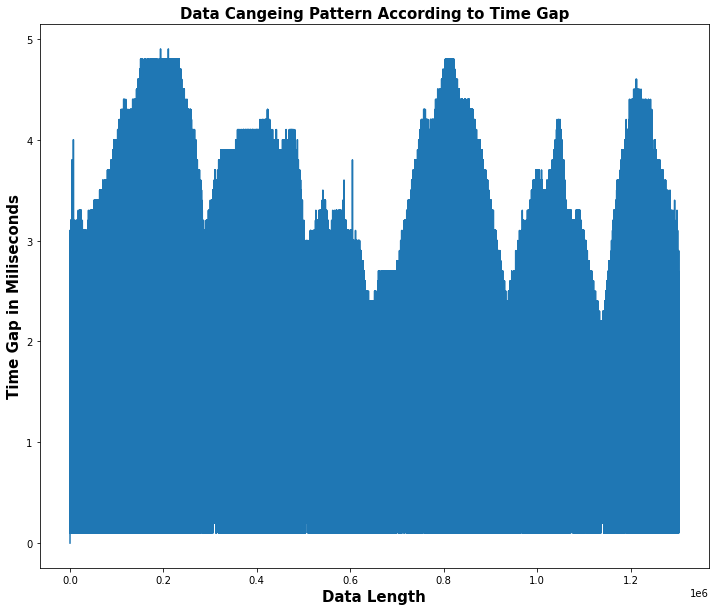

In [73]:
plt.subplots(figsize = (12, 10))
plt.plot(Car_Data_Frame['Full_Data_Time_Gap'])
plt.xlabel("Data Length", fontsize=15,  weight='bold')
plt.ylabel("Time Gap in Miliseconds", fontsize=15,  weight='bold')
plt.title("Data Cangeing Pattern According to Time Gap", fontsize=15,  weight='bold')

In [74]:
print((colored('All CAN ID List: \n\n', 'blue', attrs=['bold'])),np.unique(Car_Data_Frame.CAN_ID))
print('\n')
print(colored('Total Amount of CAN ID: ', 'red', attrs=['bold']),len(np.unique(Car_Data_Frame.CAN_ID)))

All CAN ID List: 

 ['0018' '0034' '0042' '0043' '0044' '0050' '0080' '0081' '00A0' '00A1'
 '0110' '0120' '0153' '0164' '0165' '018F' '01F1' '0220' '0260' '02A0'
 '02B0' '02C0' '0316' '0329' '0350' '0370' '0382' '043F' '0440' '04B0'
 '04B1' '04F0' '04F1' '04F2' '0510' '0517' '051A' '0545' '0587' '059B'
 '05A0' '05A2' '05E4' '05F0' '0690']


Total Amount of CAN ID:  45


In [77]:
vx1 = (pd.value_counts(Car_Data_Frame['CAN_ID'])<1000).index
vx2 = (pd.value_counts(Car_Data_Frame['CAN_ID'])<1000).values
vx = pd.concat([pd.DataFrame(vx1), pd.DataFrame(vx2)], ignore_index=True, axis=1)
vx = vx.rename(columns={0:'ID', 1:'XXX'})
vx = vx[vx['XXX']==True]
vx = vx['ID']
print(colored('Total ID used under 1000: ', 'blue', attrs=['bold']), len(vx))
print('\n')
print(colored('Total ID used under 1000 List:\n\n', 'red', attrs=['bold']), vx.values)

Total ID used under 1000:  6


Total ID used under 1000 List:

 ['0044' '0034' '05A0' '05A2' '0042' '0043']


In [79]:
v1 = (pd.value_counts(Car_Data_Frame['CAN_ID'])>=1000).index
v2 = (pd.value_counts(Car_Data_Frame['CAN_ID'])>=1000).values
v = pd.concat([pd.DataFrame(v1), pd.DataFrame(v2)], ignore_index=True, axis=1)
v = v.rename(columns={0:'ID', 1:'XXX'})
v = v[v['XXX']==True]
v = v['ID']
print(colored('Total ID used Over 3: \n\n', 'blue', attrs=['bold']) , len(v))
print('\n')
print(colored('Total ID used Over 3 List:\n\n', 'red', attrs=['bold']), v.values)

Total ID used Over 3: 

 39


Total ID used Over 3 List:

 ['0260' '0080' '0329' '02A0' '018F' '0081' '0316' '0545' '043F' '0370'
 '0440' '0164' '0220' '0153' '0165' '02B0' '0350' '04F2' '04F0' '0382'
 '04B1' '04B0' '01F1' '02C0' '04F1' '0690' '05E4' '0510' '00A0' '00A1'
 '059B' '0587' '0110' '0018' '0050' '051A' '0120' '0517' '05F0']


In [80]:
ID_based = []
v = np.unique(Car_Data_Frame.CAN_ID)
for x in v:
    ID_based.append(Car_Data_Frame[Car_Data_Frame['CAN_ID']==x])
 #------------------#   
Time_Gap_by_own_ID = []
combine_data = []
k = 0
#------------------#
for i in ID_based:
    z = i['Time']
    Time_gap = [0]
    k4 = 1
    lenth = len(z)-1
    #------------------#
    for z1 in z:
        k2 = float(np.array(z)[k4]) - float(z1)
        Time_gap.append(k2)
        if k4 >= lenth:
            break
        k4 = k4 + 1
    Time_Gap_by_own_ID.append(Time_gap)
    #------------------#
for v in range(0,len(ID_based)):
    q = pd.concat([pd.DataFrame(np.array(ID_based[v])), pd.DataFrame(np.array(Time_Gap_by_own_ID[v]))], 
                  ignore_index=True, axis=1)
    q = q.rename(columns={0:'Time', 1:'CAN_ID', 2:'DLC', 3:'Full_Payload',4:'One', 5:'Two', 6:'Three', 7:'Four', 8:'Five', 
                      9:'Six', 10:'Seven', 11:'Eight', 12:'Full_Data_Time_Gap', 13:'ID_Based_Time_Gap'})
    combine_data.append(q)
    #------------------#

In [81]:
#Filter CAN ID Input
x = '0110'

In [82]:
for i in range(0,len(combine_data)):
    if combine_data[i].CAN_ID[0] == x:
        #print(combine_data[i])
        ID_value_save = combine_data[i]

In [83]:
ID_value_save

,Time,CAN_ID,DLC,Full_Payload,One,Two,Three,Four,Five,Six,Seven,Eight,Full_Data_Time_Gap,ID_Based_Time_Gap
0,89.9,0110,8,E0 2C 20 09 00 00 00 00,E0,2C,20,09,00,00,00,00,0.3,0.0
1,190.0,0110,8,E0 2C 20 09 00 00 00 00,E0,2C,20,09,00,00,00,00,0.3,100.1
2,290.0,0110,8,E0 2C 20 09 00 00 00 00,E0,2C,20,09,00,00,00,00,0.3,100.0
3,389.8,0110,8,E0 2C 20 09 00 00 00 00,E0,2C,20,09,00,00,00,00,0.3,99.8
4,489.9,0110,8,E0 2C 20 09 00 00 00 00,E0,2C,20,09,00,00,00,00,0.3,100.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6239,623998.5,0110,8,E0 2C 20 09 00 00 00 00,E0,2C,20,09,00,00,00,00,2.2,99.9
6240,624098.5,0110,8,E0 2C 20 09 00 00 00 00,E0,2C,20,09,00,00,00,00,2.2,100.0
6241,624198.6,0110,8,E0 2C 20 09 00 00 00 00,E0,2C,20,09,00,00,00,00,0.2,100.1
6242,624298.5,0110,8,E0 2C 20 09 00 00 00 00,E0,2C,20,09,00,00,00,00,2.3,99.9
